# irt

> Some basic tooling in item response theory for analyzing the results of ML benchmarks

In [1]:
#| default_exp irt

In the following we will use item response theory (IRT) to analyze benchmark results. 

A common model in IRT is the Rasch model, which described the probability of a correct response ($P(X=1)$) as a function of the ability of the person ($\theta_n$) and the difficulty ($\beta_i$) of the item: 

$$
P(X_{ni} =1| \theta_n, \beta_i) = \frac{\exp\{\theta_n - \beta_i\}}{1 + \exp\{\theta_n - \beta_i\}}
$$

We can make this more general by adding a discrimination parameter $\alpha_i$: This parameter describes how well the item discriminates between models of different abilities. The probability of a correct response is then given by:

$$
P(X_{ni} =1| \theta_n, \beta_i, \alpha_i) = \frac{\exp\{\alpha_i(\theta_n - \beta_i)\}}{1 + \exp\{\alpha_i(\theta_n - \beta_i)\}}
$$

This is the 2PL model.

In [2]:
#| hide
from nbdev.showdoc import *

In [1]:
# | hide
import pandas as pd 
import pickle

In [2]:
# | export
import numpy as np 
from girth import twopl_mml, rasch_mml, ability_mle

In [3]:
with open('/Users/n0w0f/git/n0w0f/irt-on-bench/data/model_score_dict.pkl', 'rb') as f:
    model_score_dicts = pickle.load(f)

In [4]:
model_score_dicts['overall'].keys()

dict_keys(['Mistral-Large-2', 'Llama-3.1-70B-Instruct', 'Claude-3.5 (Sonnet)', 'Mistral-8x7b-Instruct', 'Command-R+', 'Llama-3.1-405B-Instruct', 'Llama-3.1-8B-Instruct', 'GPT-4o', 'Llama-3-70B-Instruct', 'PaperQA2', 'Gemma-1.1-7B-it', 'Gemma-2-9B-it', 'Llama-2-70B Chat', 'Galatica-120b', 'Llama-3-8B-Instruct', 'Gemini-Pro', 'o1', 'GPT-4', 'Phi-3-Medium-4k-Instruct', 'Claude-3 (Opus)', 'GPT-3.5 Turbo Zero-T', 'Claude-2-Zero-T'])

In [133]:
model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_']

0       False
1        True
2       False
3        True
4        True
        ...  
2849     True
2850     True
2851    False
2852     True
2853     True
Name: all_correct_, Length: 2854, dtype: bool

In [5]:
models = list(model_score_dicts['overall'].keys())
binary_matrix = np.zeros((len(model_score_dicts['overall']['Claude-3.5 (Sonnet)']), len(models)))

for i, model in enumerate(models):
   binary_matrix[:,i] = model_score_dicts['overall'][model]['all_correct_'].values

# Convert to pandas DataFrame for better visualization
binary_df = pd.DataFrame(binary_matrix, columns=models)

In [6]:
# create array from dataframe
binary_array = binary_df.to_numpy()


In [ ]:
# i want a binary matrix  rows are score for questions and columns are models
#model_score_dicts['overall'].keys() gives model name
# model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_'] gives the score for the model



In [120]:
# | export
from enum import Enum
from dataclasses import dataclass
from typing import Dict

In [121]:
# | export
class ScoringType(Enum): 
    BINARY = 'binary'
    PARTIAL = 'partial'

We define a container to store meta information for each question (item). We will track some identifier and what type of scoring the question uses.

In [122]:
# | export

@dataclass
class QuestionMetadata:
    """Base class for question metadata"""
    question_id: str
    scoring_type: ScoringType

    def compute_score(self, response) -> float:
        """Base method for computing scores"""
        raise NotImplementedError
    



In [123]:
# | export

@dataclass
class BinaryQuestionMetadata(QuestionMetadata):
    """Metadata for binary scored questions"""
    def __init__(self, question_id: str):
        super().__init__(question_id, ScoringType.BINARY)

    def compute_score(self, row, column: str='all_correct_') -> float:
        """Use the all_correct column directly"""
        return float(row[column])

In [124]:
# | export

class BenchmarkAnalyzer:
    def __init__(self):
        self.model_dataframes: Dict[str, pd.DataFrame] = {}
        self.question_metadata: Dict[str, QuestionMetadata] = {}
        self.score_matrix = None
        self.model_ids = None

    def add_model_results(self, model_id: str, results_df: pd.DataFrame):
        """Add a model's results DataFrame"""
        self.model_dataframes[model_id] = results_df

    def add_question_metadata(self, metadata: QuestionMetadata):
        """Add metadata for a question"""
        self.question_metadata[metadata.question_id] = metadata

    def compute_score_matrix(self) -> np.ndarray:
        """Compute score matrix using metadata-specific scoring"""
        if not self.model_dataframes or not self.question_metadata:
            raise ValueError("Need both model results and question metadata")

        self.model_ids = list(self.model_dataframes.keys())
        question_ids = list(self.question_metadata.keys())

        # Initialize score matrix
        self.score_matrix = np.full(
            (len(self.model_ids), len(question_ids)), 
            np.nan
        )

        # Compute scores
        for model_idx, model_id in enumerate(self.model_ids):
            df = self.model_dataframes[model_id]
            for q_idx, q_id in enumerate(question_ids):
                if q_id not in df.index:
                    continue

                metadata = self.question_metadata[q_id]
                row = df.loc[q_id]

                self.score_matrix[model_idx, q_idx] = metadata.compute_score(row)


        return self.score_matrix

    def fit_irt(self, model='2pl') -> Dict[str, pd.DataFrame]:
        if self.score_matrix is None:
            self.compute_score_matrix()

        binary_matrix = (self.score_matrix >= 0.5).astype(int).T #  needs to be [n_items, n_participants]
        
        if model == '2pl':
            # options = {
            # 'max_iteration': 200,
            # 'quadrature_n': 61,  # More quadrature points for better precision
            # 'quadrature_bounds': (-6, 6),  # Default bounds
            # 'estimate_distribution': True  # Allow distribution estimation
            # }

            results = twopl_mml(binary_matrix)
            difficulties = results['Difficulty']
            discriminations = results['Discrimination']
        else:  # rasch
            results = rasch_mml(binary_matrix)
            difficulties = results['Difficulty']
            discriminations = np.ones_like(difficulties) 
        
        abilities = ability_mle(
            binary_matrix,  
            difficulties,
            discriminations,
            no_estimate=np.nan  
        )

        return {
            'difficulties': difficulties,
            'discriminations': discriminations,
            'abilities': abilities, 
            'binary_matrix': binary_matrix
        }


    def analyze_extreme_items(difficulties, discriminations, question_ids, threshold=0.95):
        """Identify items with extreme parameters"""
        extreme_items = pd.DataFrame({
            'question_id': question_ids,
            'difficulty': difficulties,
            'discrimination': discriminations
        })

        # Find items with extreme values
        extreme_items['is_extreme'] = (
            (discriminations > threshold * 5.0) |  # High discrimination
            (difficulties > threshold * 6.0) |     # Very difficult
            (difficulties < -4.0)                  # Very easy
        )

        return extreme_items[extreme_items['is_extreme']]



Now, let's the class with some of our data

In [125]:
analyzer = BenchmarkAnalyzer()

for model_id, df in model_score_dicts['overall'].items():
    analyzer.add_model_results(model_id, df)


# for now, let's just add the binary questions

for i, row in model_score_dicts['overall']['Claude-2-Zero-T'].iterrows():
    if row['metrics_hamming']:
        analyzer.add_question_metadata(BinaryQuestionMetadata(i))


In [126]:
len(analyzer.question_metadata)

1614

In [127]:
results = analyzer.fit_irt(model='rasch')

/Users/n0w0f/miniconda3/envs/irt/lib/python3.11/site-packages/girth/unidimensional/dichotomous/rasch_mml.py:108: RuntimeWarning: divide by zero encountered in log
  return -np.log(otpt).dot(counts)


In [128]:
results['abilities']

array([ 0.92062274,  0.70085661,  0.43172056, -0.33257593,  0.18210808,
        0.97653286,  0.26776643,  0.95411399,  0.46383346,  0.73349057,
       -1.47287807,  0.30697452, -1.099009  , -4.0792575 ,  0.28559071,
        0.27133169,  1.18214098, -0.5245331 ,  0.32122829, -0.2613409 ,
        0.20711413, -3.02995173])

In [131]:
# print how many zeros in matrix
print(results['binary_matrix'].shape )

(1614, 22)


In [14]:
dict(zip(analyzer.model_ids, results['abilities']))

{'Mistral-Large-2': 0.9206227382517711,
 'Llama-3.1-70B-Instruct': 0.7008566079326864,
 'Claude-3.5 (Sonnet)': 0.43172056318578506,
 'Mistral-8x7b-Instruct': -0.33257592815906706,
 'Command-R+': 0.18210807975250953,
 'Llama-3.1-405B-Instruct': 0.976532863706392,
 'Llama-3.1-8B-Instruct': 0.26776643434833536,
 'GPT-4o': 0.954113987494647,
 'Llama-3-70B-Instruct': 0.46383345663883774,
 'PaperQA2': 0.7334905687001801,
 'Gemma-1.1-7B-it': -1.472878071397841,
 'Gemma-2-9B-it': 0.30697451785597074,
 'Llama-2-70B Chat': -1.0990090007354893,
 'Galatica-120b': -4.079257501775907,
 'Llama-3-8B-Instruct': 0.2855907076410609,
 'Gemini-Pro': 0.2713316860822229,
 'o1': 1.1821409799492104,
 'GPT-4': -0.5245330961997795,
 'Phi-3-Medium-4k-Instruct': 0.32122828793906116,
 'Claude-3 (Opus)': -0.2613409044033738,
 'GPT-3.5 Turbo Zero-T': 0.2071141267589506,
 'Claude-2-Zero-T': -3.0299517299011396}

This seems to be quite different from a naive ranking based on taking the mean of the scores.
Let's perform some more detailed analysis what causes the differences.

In [16]:
def analyze_influential_questions(binary_matrix, abilities, difficulties, discriminations, model_ids, question_ids):
    """Analyze which questions cause the biggest differences between IRT and average scoring"""

    # Get both scoring methods
    avg_scores = np.mean(binary_matrix.T, axis=1)
    print(avg_scores.shape)

    # Create base comparison DataFrame
    model_comparison = pd.DataFrame({
        'model_id': model_ids,
        'irt_ability': abilities,
        'avg_score': avg_scores,
        'irt_rank': pd.Series(abilities).rank(ascending=False),
        'avg_rank': pd.Series(avg_scores).rank(ascending=False)
    }).set_index('model_id')
    print(model_comparison)

    # Find models with large ranking differences
    model_comparison['rank_diff'] = model_comparison['avg_rank'] - model_comparison['irt_rank']
    interesting_models = model_comparison[abs(model_comparison['rank_diff']) > 2]

    # Analyze question characteristics for these models
    question_analysis = pd.DataFrame({
        'question_id': question_ids,
        'difficulty': difficulties,
        'discrimination': discriminations,
        'avg_success_rate': np.mean(binary_matrix.T, axis=0)
    })

    # For each interesting model, analyze its response pattern
    for model_id in interesting_models.index:
        model_idx = model_ids.index(model_id)
        responses = binary_matrix[model_idx]

        # Calculate contribution to IRT score
        # Higher contribution when succeeding on difficult/discriminating items
        question_analysis[f'{model_id}_contribution'] = (
            responses * discriminations * (difficulties - abilities[model_idx])
        )

        # Add raw response
        question_analysis[f'{model_id}_response'] = responses

    # Find most influential questions
    influential_questions = question_analysis[
        (question_analysis['discrimination'] > np.percentile(discriminations, 75)) |
        (abs(question_analysis['difficulty']) > 2)
    ]

    return {
        'model_differences': interesting_models,
        'influential_questions': influential_questions.sort_values('discrimination', ascending=False)
    }

# Example usage:
influential_analysis_results = analyze_influential_questions(
    results['binary_matrix'],
    results['abilities'], 
    results['difficulties'], 
    results['discriminations'], 
    analyzer.model_ids, 
    list(analyzer.question_metadata.keys())
)

print("\nModels with largest ranking differences:")
print(influential_analysis_results['model_differences'])


(22,)
                          irt_ability  avg_score  irt_rank  avg_rank
model_id                                                            
Mistral-Large-2              0.920623   0.545849       4.0       4.0
Llama-3.1-70B-Instruct       0.700857   0.508674       6.0       6.0
Claude-3.5 (Sonnet)          0.431721   0.462206       8.0       8.0
Mistral-8x7b-Instruct       -0.332576   0.331475      17.0      17.0
Command-R+                   0.182108   0.418835      15.0      15.0
Llama-3.1-405B-Instruct      0.976533   0.555143       2.0       2.0
Llama-3.1-8B-Instruct        0.267766   0.433705      13.0      13.0
GPT-4o                       0.954114   0.551425       3.0       3.0
Llama-3-70B-Instruct         0.463833   0.467782       7.0       7.0
PaperQA2                     0.733491   0.514250       5.0       5.0
Gemma-1.1-7B-it             -1.472878   0.169765      20.0      20.0
Gemma-2-9B-it                0.306975   0.440520      10.0      10.0
Llama-2-70B Chat            

In [17]:

print("\nMost influential questions:")
print(influential_analysis_results['influential_questions'].head(10))


Most influential questions:
     question_id  difficulty  discrimination  avg_success_rate
0              0    2.173210             1.0          0.136364
821         1450    2.173210             1.0          0.136364
892         1585    5.999939             1.0          0.000000
884         1566    2.679903             1.0          0.090909
862         1527   -3.477644             1.0          0.954545
849         1498    2.173210             1.0          0.136364
848         1497    2.173210             1.0          0.136364
835         1471    3.477478             1.0          0.045455
828         1462    5.999939             1.0          0.000000
824         1454    2.173210             1.0          0.136364


In [18]:
model_score_dicts['overall']['GPT-4'].iloc[1879]

canary_0                   BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
description_0                                    Distribution of antibiotics
keywords_0                 [antibiotic, distribution, pharmacokinetics, r...
llm_extraction_count_0                                                     0
metrics_correct_classes                                                  1.0
                                                 ...                        
is_materials_science                                                   False
is_molsim                                                              False
requires_calculation                                                     NaN
is_preference                                                          False
is_name                                                                False
Name: 1879, Length: 77, dtype: object

In [19]:
#| hide
import nbdev; nbdev.nbdev_export()

<Axes: >

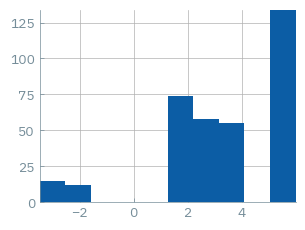

In [20]:
influential_analysis_results['influential_questions']['difficulty'].hist()

In [21]:
influential_analysis_results['influential_questions'][influential_analysis_results['influential_questions']['difficulty']<0]

,question_id,difficulty,discrimination,avg_success_rate
862,1527,-3.477644,1.0,0.954545
894,1590,-2.173275,1.0,0.863636
898,1595,-2.173275,1.0,0.863636
998,1778,-2.173275,1.0,0.863636
996,1775,-2.679993,1.0,0.909091
899,1596,-2.173275,1.0,0.863636
563,977,-2.173275,1.0,0.863636
544,946,-2.173275,1.0,0.863636
1448,2563,-3.477644,1.0,0.954545
1349,2386,-2.679993,1.0,0.909091


In [22]:
model_score_dicts['overall']['GPT-4'].iloc[1590]['prompt_0']

"The following is a question about chemistry.\n\nQuestion: The reaction of sulfur dioxide with calcium carbonate and oxygen is 2SO2 + 2CaCO3 + O2 -> xCaSO4 + 2CO2. What is x?\n\nYou MUST include the final answer within the following tags: [ANSWER] and [/ANSWER].\nFor example, '[ANSWER]<answer>[/ANSWER]', where <answer> is only one number. Always answer in exactly this format, with ONE NUMBER between the two tags, even if you are unsure. Use dots as decimal separator. We require this because we use automatic parsing."

Let's see if we can make it Bayesian with `pymc`

In [7]:
import pymc as pm
import numpy as np
import arviz as az

def fit_2pl_pymc(response_matrix, n_samples=2000, tune=2000):
    n_participants, n_items = response_matrix.shape

    with pm.Model() as irt_2pl:
        # 1. Standardize input data if not already done
        # response_matrix = (response_matrix - np.mean(response_matrix)) / np.std(response_matrix)

        # 2. Abilities with stronger regularization
        abilities = pm.Normal('abilities', 
                            mu=0, 
                            sigma=0.5,  # Tighter prior
                            shape=n_participants)

        # 3. Simpler discrimination parameterization
        # Constrain to reasonable range [0.5, 2.5]
        discriminations = pm.TruncatedNormal('discriminations',
                                           mu=1.0,
                                           sigma=0.3,
                                           lower=0.5,
                                           upper=2.5,
                                           shape=n_items)

        # 4. Difficulties with tighter bounds
        difficulties = pm.TruncatedNormal('difficulties',
                                        mu=0,
                                        sigma=0.5,
                                        lower=-2,
                                        upper=2,
                                        shape=n_items)

        # 5. More stable computation with scaling
        scaled_abilities = abilities[:, None] / 2.0  # Scale down
        scaled_difficulties = difficulties[None, :] / 2.0
        scaled_disc = discriminations[None, :] / 2.0

        # Compute logit with scaled parameters
        logit_p = scaled_disc * (scaled_abilities - scaled_difficulties)

        # 6. Likelihood
        responses = pm.Bernoulli('responses',
                                logit_p=logit_p,
                                observed=response_matrix)

        # 7. Improved sampling settings
        trace = pm.sample(n_samples,
                         tune=tune,
                         chains=4,
                         target_accept=0.99,
                         init='jitter+adapt_diag',  # Different initializer
                         return_inferencedata=True,
                         cores=1)  # Single core for better stability

    return trace

# Modern diagnostics using ArviZ
def check_model_diagnostics(trace):
    """Comprehensive model diagnostics"""
    diagnostics = {
        'r_hat': az.rhat(trace),
        'ess': az.ess(trace),
        'mcse': az.mcse(trace),
        'divergences': az.summary(trace)['diverging'].sum()
    }

    # Check for convergence issues
    has_issues = (
        (diagnostics['r_hat'] > 1.01).any() or
        (diagnostics['ess'] < 400).any() or
        diagnostics['divergences'] > 0
    )

    if has_issues:
        print("Warning: Potential convergence issues detected")

    return diagnostics


In [8]:
with pm.Model() as model:
    trace_all_correct = fit_2pl_pymc(binary_array.T)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


/Users/n0w0f/miniconda3/envs/irt/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1991 seconds.


In [9]:
# save trace as pickle file
with open('/Users/n0w0f/git/n0w0f/irt-on-bench/data/trace_all_correct.pkl', 'wb') as f:
    pickle.dump(trace_all_correct, f)

In [15]:
difficulty_vector = trace_all_correct.posterior['difficulties'].mean(dim=['chain', 'draw']).values

In [16]:
# load json file
import json
with open('/Users/n0w0f/git/n0w0f/irt-on-bench/data/difficulty_dict.json', 'r') as f:
    difficulty_dict = json.load(f)

In [20]:
difficulty_vector_dataframe = pd.DataFrame(difficulty_vector, columns=['difficulty'])

In [25]:
difficulty_vector_dataframe

,difficulty,difficulty_level
0,0.445558,NaN
1,0.007056,NaN
2,0.648156,NaN
3,-0.632799,NaN
4,-0.569641,NaN
...,...,...
2849,-0.439174,NaN
2850,0.007702,NaN
2851,0.282358,NaN
2852,0.371108,NaN


In [23]:
difficulty_vector_dataframe

#extend the difficulty dataframe with one more column based on the index. Use the difficulty_dict to assign values to the new column. all index that are easy is 0, intermediate is 1 and hard is 2

difficulty_vector_dataframe['difficulty_level'] = difficulty_vector_dataframe.index.map(difficulty_dict)

In [27]:
# Create mapping dictionary with default value 
level_map = {i: 2 for i in range(len(difficulty_vector))}  # Default to 'hard' (2)

# Map easy indices to 0
for i in difficulty_dict['easy']:
   level_map[i] = 0
   
# Map intermediate indices to 1
for i in difficulty_dict['intermediate']: 
   level_map[i] = 1

# Add new column
difficulty_vector_dataframe['difficulty_level'] = difficulty_vector_dataframe.index.map(level_map)

In [144]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.constants import golden

plt.style.use("lamalab.mplstyle")

ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2
ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

def range_frame(ax, x, y, pad=0.1):
    y_min, y_max = np.min(y), np.max(y)
    x_min, x_max = np.min(x), np.max(x)
    
    ax.set_ylim(y_min - pad * (y_max - y_min), 
                y_max + pad * (y_max - y_min))
    # ax.set_xlim(x_min * (1 - pad), 
    #             x_max * (1 + pad))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_bounds(y_min, y_max)
    ax.spines['bottom'].set_bounds(x_min, x_max)

def plot_difficulty_violin(df):
   plt.figure(figsize=(ONE_COL_WIDTH_INCH, 1.2 *ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
   
   # Create violin plot
   ax = sns.violinplot(data=df, x='difficulty_level', y='difficulty', color="#FFBA08",linewidth=0.75)
   
   # Apply range frame
   x = df['difficulty_level'].unique()
   y = df['difficulty'].values
   range_frame(ax, x, y)
   
   # Customize labels
   ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])

#    plt.title('Difficulty Distribution')
   plt.xlabel('Human Assigned')
   plt.ylabel('Computed Difficulty')
   
   plt.tight_layout()
   plt.savefig("difficulty.pdf", format='pdf')

   plt.show()


/var/folders/tw/1gbrp83s7273pmjr95nyvj800000gn/T/ipykernel_32118/1313478027.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])


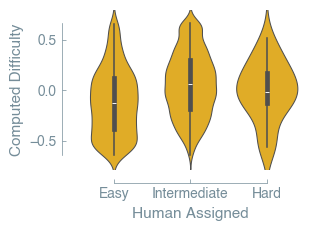

In [145]:
plot_difficulty_violin(difficulty_vector_dataframe)

In [61]:
abilities_mean = trace_all_correct.posterior['abilities'].mean(dim=['chain', 'draw']).values

In [66]:
len(abilities_mean)

22

In [75]:
sum(model_score_dicts['overall']['Mistral-Large-2']['all_correct_'])/len(model_score_dicts['overall']['Mistral-Large-2']['all_correct_'])

0.5567624386825508

In [77]:
model_list = list(model_score_dicts['overall'].keys())

model_score_list = []
for model in model_list:
    #print(sum(model_score_dicts['overall'][model]['all_correct_'])/len(model_score_dicts['overall'][model]['all_correct_']))
    model_score_list.append(sum(model_score_dicts['overall'][model]['all_correct_'])/len(model_score_dicts['overall'][model]['all_correct_']))

In [81]:
# i want to create a dataframe with model names and their scores
model_score_df = pd.DataFrame(model_score_list, index=model_list, columns=['score'])


In [152]:
def plot_model_comparison(df, abilities_mean, models_to_plot=None, colors=None):
   fig, ax = plt.subplots(figsize=(1.5*ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
   
   abilities_norm = abilities_mean #(abilities_mean - abilities_mean.min()) / (abilities_mean.max() - abilities_mean.min())
   
   if models_to_plot is None:
       models_to_plot = df.index
       
   if colors is None:
       colors = ['#6A040F', '#03071E', '#D00000', '#DC2F02', '#E85D04', '#FAA307', '#FFBA08']

   x = np.array([0, 1])
   for i, model in enumerate(models_to_plot):
       idx = df.index.get_loc(model)
       y = np.array([df.loc[model, 'score'], abilities_norm[idx]])
       plt.plot(x, y, '-', label=model, color=colors[i % len(colors)],linewidth=1.5)

   plt.xticks([0, 1], ['Average', 'IRT'])
   plt.ylabel('Score')
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   range_frame(ax, x, np.concatenate([df.loc[models_to_plot, 'score'], abilities_norm[[df.index.get_loc(m) for m in models_to_plot]]]))
   plt.tight_layout()
   plt.savefig("model_comparison.pdf", format='pdf')
   plt.show()

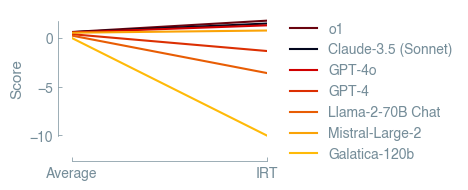

In [153]:
models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'GPT-4o', 'GPT-4',
'Llama-2-70B Chat', 'Mistral-Large-2', 'Galatica-120b']
plot_model_comparison(model_score_df, abilities_mean, models_to_plot)

In [111]:
model_score_df

,score
Mistral-Large-2,0.556762
Llama-3.1-70B-Instruct,0.500000
Claude-3.5 (Sonnet),0.610371
Mistral-8x7b-Instruct,0.414506
Command-R+,0.439033
Llama-3.1-405B-Instruct,0.565872
Llama-3.1-8B-Instruct,0.460757
GPT-4o,0.596706
Llama-3-70B-Instruct,0.506307
PaperQA2,0.555711


In [85]:
# plot score from the dataframe and abilities_mean

def plot_score_vs_ability(model_score_df, abilities_mean):
    plt.figure(figsize=(ONE_COL_WIDTH_INCH, 1.2 *ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    plt.scatter(model_score_df['score'], abilities_mean, color="#3A9185")
    plt.xlabel('Model Score')
    plt.ylabel('Computed Ability')
    plt.tight_layout()
    plt.savefig("score_vs_ability.pdf", format='pdf')
    plt.show()

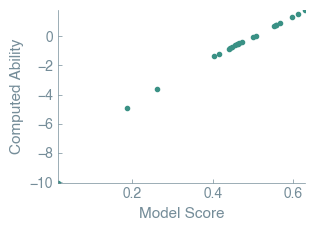

In [86]:
plot_score_vs_ability(model_score_df, abilities_mean)

In [ ]:
plt.style.use('lamalab.mplstyle')
plt.figure(figsize=(12, 6))
metrics = ['unweighted_mean', 'weighted_mean_0', 'weighted_mean_1',
'hamming_mean', 'precision_mean', 'recall_mean']
labels = ['all correct', 'Weighted all correct', 'Equal weights per question',
'Normalized, inverted hamming loss', 'Precision', 'Recall']
for model in selected_models:
    plt.plot(metrics, metrics_df.loc[model], 'o-', label=model, alpha=0.7, linewidth=1)
    plt.xticks(range(len(metrics)), labels, rotation=45)
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("chembench_scoring.png")

In [39]:
# 1. Basic summary statistics
summary = az.summary(trace, var_names=['abilities', 'discriminations', 'difficulties'])

# 2. Extract posterior means directly
abilities_mean = trace.posterior['abilities'].mean(dim=['chain', 'draw']).values
discriminations_mean = trace.posterior['discriminations'].mean(dim=['chain', 'draw']).values
difficulties_mean = trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values

# 3. Get full posterior distributions
abilities_dist = trace.posterior['abilities'].values
discriminations_dist = trace.posterior['discriminations'].values
difficulties_dist = trace.posterior['difficulties'].values

# 4. Get credible intervals
summary = az.summary(trace, var_names=['abilities', 'discriminations', 'difficulties'],
                    hdi_prob=0.95)  # 95% credible intervals


In [31]:
difficulty_vector = pd.DataFrame(trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values)


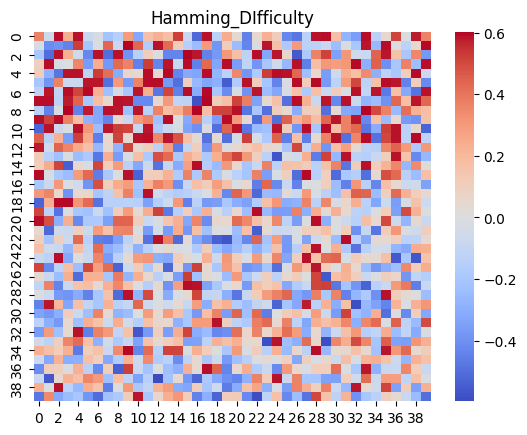

Used 1600 elements out of 1614


In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_vector_as_square_heatmap(vector, title):
    # Calculate the size of the square matrix
    n = int(np.sqrt(len(vector)))
    # Reshape first n^2 elements into square matrix
    matrix = vector[:n*n].values.reshape(n, n)
    
    sns.heatmap(matrix, cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.show()
    
    return n*n  # Return number of elements used

used_elements = plot_vector_as_square_heatmap(difficulty_vector, "Hamming_DIfficulty")
print(f"Used {used_elements} elements out of {len(difficulty_vector)}")

In [28]:
! pip install seaborn

In [40]:
list(summary.index)

['abilities[0]',
 'abilities[1]',
 'abilities[2]',
 'abilities[3]',
 'abilities[4]',
 'abilities[5]',
 'abilities[6]',
 'abilities[7]',
 'abilities[8]',
 'abilities[9]',
 'abilities[10]',
 'abilities[11]',
 'abilities[12]',
 'abilities[13]',
 'abilities[14]',
 'abilities[15]',
 'abilities[16]',
 'abilities[17]',
 'abilities[18]',
 'abilities[19]',
 'abilities[20]',
 'abilities[21]',
 'discriminations[0]',
 'discriminations[1]',
 'discriminations[2]',
 'discriminations[3]',
 'discriminations[4]',
 'discriminations[5]',
 'discriminations[6]',
 'discriminations[7]',
 'discriminations[8]',
 'discriminations[9]',
 'discriminations[10]',
 'discriminations[11]',
 'discriminations[12]',
 'discriminations[13]',
 'discriminations[14]',
 'discriminations[15]',
 'discriminations[16]',
 'discriminations[17]',
 'discriminations[18]',
 'discriminations[19]',
 'discriminations[20]',
 'discriminations[21]',
 'discriminations[22]',
 'discriminations[23]',
 'discriminations[24]',
 'discriminations[25]',


In [44]:
# Get point estimates and uncertainty
def get_parameter_estimates(trace):
    estimates = {
        'abilities': {
            'mean': trace.posterior['abilities'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['abilities'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['abilities'])
        },
        'discriminations': {
            'mean': trace.posterior['discriminations'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['discriminations'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['discriminations'])
        },
        'difficulties': {
            'mean': trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['difficulties'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['difficulties'])
        }
    }
    return estimates


In [45]:
estimates = get_parameter_estimates(trace)

In [46]:
dict(zip(analyzer.model_ids, estimates['abilities']['mean']))

{'Mistral-Large-2': 0.4580667032974997,
 'Llama-3.1-70B-Instruct': -0.07793879274298017,
 'Claude-3.5 (Sonnet)': -0.6700002913364688,
 'Mistral-8x7b-Instruct': -2.3490229216075624,
 'Command-R+': -1.1730601421949194,
 'Llama-3.1-405B-Instruct': 0.5921608201060119,
 'Llama-3.1-8B-Instruct': -0.9785653849577762,
 'GPT-4o': 0.4981269288420167,
 'Llama-3-70B-Instruct': -0.607989293845749,
 'PaperQA2': 0.05055868388896333,
 'Gemma-1.1-7B-it': -4.895052190773771,
 'Gemma-2-9B-it': -0.883897051887834,
 'Llama-2-70B Chat': -4.066615761763882,
 'Galatica-120b': -8.370154796213088,
 'Llama-3-8B-Instruct': -0.9035605387637059,
 'Gemini-Pro': -0.9622151329026539,
 'o1': 1.0158636748513077,
 'GPT-4': -2.8381532745919102,
 'Phi-3-Medium-4k-Instruct': -0.8452802334086583,
 'Claude-3 (Opus)': -2.2368780397563657,
 'GPT-3.5 Turbo Zero-T': -1.1187322243879676,
 'Claude-2-Zero-T': -7.556805116366585}